In [56]:
import PyTimber_Tom, pagestore
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import csv,glob, datetime, collections, time, subprocess,os, itertools

from scipy import optimize as opt
from scipy import constants as const
from StringIO import StringIO
from matplotlib import rc,rcParams
from matplotlib.patches import Rectangle

from pandas import HDFStore 
from collections import namedtuple

# simdata
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import scatter_matrix

# ---------------------------------------------------------------------------
# check available diskspace
# ---------------------------------------------------------------------------
DiskUsage = namedtuple('DiskUsage','Total used free')
def disk_usage(path):
    st     = os.statvfs(path)
    free   = st.f_bavail * st.f_frsize
    total  = st.f_blocks * st.f_frsize
    used   = (st.f_blocks - st.f_bfree) * st.f_frsize
    return DiskUsage(total, used,free)


# ---------------------------------------------------------------------------
# fucntion to get a list of fills in a user defined time interval
# ---------------------------------------------------------------------------
def getfills(t1,t2):
    db     = pytimber.LoggingDB()
    fills  = db.get('HX:FILLN',t1,t2)
    t,v    = fills['HX:FILLN']
    df     = pd.DataFrame(np.vstack((t,v)).T,columns=['UnixTime','Fill'])
    df['Timestamp'] = pd.to_datetime(df['UnixTime'],unit='s')
    return df

# --------------------
# returns fill summary
# --------------------
def getsummary(fill):
    db     = pytimber.LoggingDB()
    if type(fill) == int:
        try:
            summary = db.getLHCFillData(fill)
        except:
            print 'Something went wrong no fill data loaded.'
    else:
        print 'Fillnumber needs to be integer ! Try again.'

In [112]:
summary = db.getLHCFillData(4696)
summary

{'beamModes': [{'endTime': 1449365454.123,
   'mode': u'SETUP',
   'startTime': 1449364630.386},
  {'endTime': 1449369654.556, 'mode': u'INJPROT', 'startTime': 1449365454.124},
  {'endTime': 1449372698.952, 'mode': u'INJPHYS', 'startTime': 1449369654.557},
  {'endTime': 1449374737.837, 'mode': u'INJPROT', 'startTime': 1449372698.953},
  {'endTime': 1449375818.005, 'mode': u'INJPHYS', 'startTime': 1449374737.838},
  {'endTime': 1449381701.018, 'mode': u'INJPHYS', 'startTime': 1449375818.006},
  {'endTime': 1449382026.776, 'mode': u'PRERAMP', 'startTime': 1449381701.019},
  {'endTime': 1449383254.726, 'mode': u'RAMP', 'startTime': 1449382026.777},
  {'endTime': 1449383456.85, 'mode': u'FLATTOP', 'startTime': 1449383254.727},
  {'endTime': 1449383857.318, 'mode': u'SQUEEZE', 'startTime': 1449383456.851},
  {'endTime': 1449384644.837, 'mode': u'SQUEEZE', 'startTime': 1449383857.319},
  {'endTime': 1449385433.245, 'mode': u'ADJUST', 'startTime': 1449384644.838},
  {'endTime': 1449405157.208

In [113]:
summary.keys()
sum2 = summary['beamModes']
summary.pop('beamModes',None)
# sum2.update(summary)
summary['mode'] = summary.pop('fillNumber')
sum2[:0] = [summary]

In [116]:
dfsum = pd.DataFrame.from_dict(sum2)
dfsum

,endTime,mode,startTime
0,1.449406e+09,4696,1.449363e+09
1,1.449365e+09,SETUP,1.449365e+09
2,1.449370e+09,INJPROT,1.449365e+09
3,1.449373e+09,INJPHYS,1.449370e+09
4,1.449375e+09,INJPROT,1.449373e+09
5,1.449376e+09,INJPHYS,1.449375e+09
6,1.449382e+09,INJPHYS,1.449376e+09
7,1.449382e+09,PRERAMP,1.449382e+09
8,1.449383e+09,RAMP,1.449382e+09
9,1.449383e+09,FLATTOP,1.449383e+09


In [84]:
# --------------------
# returns fill summary
# --------------------
def getsummary(self):
        # check if already present in hdf file
        if '/summary' in hdffill.keys():
            dfsummary = hdffill['/summary']
        else:
            infn   = "Fill" + str(self.fillnumber) + "Summary"
            bashcmd1 = "./cern-ldb -M FD -fn " + str(self.fillnumber) + " -N  " + infn + " -F CSV"
            bashcmd2 = "rm " + infn + ".CSV "
            subprocess.call(bashcmd1,shell=True)
            subprocess.call(bashcmd2,shell=True)
            dfsummary = pd.read_csv(infn + ".CSV",delimiter=',',header=0)
            hdffill.put('summary',dfsummary,format='table')
        return dfsummary

In [55]:


class LHCfill(object):
    # path to file with horizontal bpm names,etc
    timbernames = '/afs/cern.ch/user/t/tomerten/public/timbernames.h5'
    hdftimbernames = HDFStore(timbernames)
    
    # names of timberdata we want to extract
    timbervarFBCTB1    = 'LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'
    timbervarFBCTB2    = 'LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'

    timbervarBQMB1L    = 'LHC.BQM.B1:BUNCH_LENGTHS'
    timbervarBQMB1F    = 'LHC.BQM.B1:FILLED_BUCKETS'

    timbervarBQMB2L    = 'LHC.BQM.B2:BUNCH_LENGTHS'
    timbervarBQMB2F    = 'LHC.BQM.B2:FILLED_BUCKETS'

    timbervarBSRTB1H   = 'LHC.BSRT.5R4.B1:FIT_SIGMA_H'
    timbervarBSRTB1V   = 'LHC.BSRT.5R4.B1:FIT_SIGMA_V'
    timbervarBSRTB1GD  = 'LHC.BSRT.5R4.B1:GATE_DELAY'
    timbervarBSRTB1CH  = 'LHC.BSRT.5R4.B1:LSF_H'
    timbervarBSRTB1CV  = 'LHC.BSRT.5R4.B1:LSF_V'

    timbervarBSRTB2H   = 'LHC.BSRT.5L4.B2:FIT_SIGMA_H'
    timbervarBSRTB2V   = 'LHC.BSRT.5L4.B2:FIT_SIGMA_V'
    timbervarBSRTB2GD  = 'LHC.BSRT.5L4.B2:GATE_DELAY'
    timbervarBSRTB2CH  = 'LHC.BSRT.5L4.B2:LSF_H'
    timbervarBSRTB2CV  = 'LHC.BSRT.5L4.B2:LSF_V'

    timbervarLumiAtlas = "ATLAS:LUMI_TOT_INST"
    timbervarLumiAlice = "ALICE:LUMI_TOT_INST"
    timbervarLumiCMS   = "CMS:LUMI_TOT_INST"
    timbervarLumiLHCB  = "LHCB:LUMI_TOT_INST"
    
    timbervarhorbpm    = 'LHC.BOFSU:POSITIONS_H'
    
    fillkeys = ['/summary',
                '/bpmhor/bpmdata',
                '/bpmhor/bpmmask',
                 '/bunchintensity/b1',
                 '/bunchintensity/b1pos',
                 '/bunchintensity/b2',
                 '/bunchintensity/b2pos',
                 '/bunchlenght/b1',
                 '/bunchlenght/b1pos',
                 '/bunchlenght/b2',
                 '/bunchlenght/b2pos',
                 '/emit/ex1',
                 '/emit/ex2',
                 '/emit/ey1',
                 '/emit/ey2',
                 '/lumi/alice',
                 '/lumi/atlas',
                 '/lumi/cms',
                 '/lumi/lhcb']
    # constants
    protonmass = const.physical_constants['proton mass energy equivalent in MeV'][0]/1000 # GeV
    ionA       = 208.
    ionZ       = 82.
    energy     = 6370
    gamma      = energy * ionZ / 193.7291748489224

    # beta's for the undulators and dipoles for the bsrt light
    betaUndH = [203.,200.]
    betaUndV = [318.,327.]
    betaDipH = [214., 205.]
    betaDipV = [328.,344.]
    
    #--------------------------------------------------------------------------------------------------
    # initialization :
    # ----------------
    # fillnumber                : int
    # basedir                   : string
    # summarydf                 : pandas dataframe
    # bunchlenb1df,bunchlenb1df : pandas dataframe
    # ex1df,ey1df,ex2df,ey2df   : pandas dataframe
    # I1df, I2df                : pandas dataframe
    # lumiatlasdf,lumicmsdf,lumialicedf,lumilhcbdf : pandas dataframe
    # bpmhdf                    : pandas dataframe
    # bpmhmask                  : pandas dataframe
    #--------------------------------------------------------------------------------------------------
    
    
    def __init__(self,fillnumber,basedir):
        # creating/opening hdf5 file for retreiving or appending data
        fillfn         = basedir + str(fillnumnber) + '.h5'
        hdffill        = HDFStore(fillfn)
                
        self.fillnumber = fillnumber
        self.basedir    = basedir
        
        self.summary    = self.getsummary()
        
        self.bunchlenb1df, self.bunch2enb1df = self.getbunchlenghts('Fill' + str(self.fillnumber) + 'BLb1',
                                                                    'Fill' + str(self.fillnumber) + 'BLb2')
        
        self.ex1df,self.ey1df,self.ex2df,self.ey2df = self.getemitbsrt('Fill' + str(self.fillnumber) +'emit1',
                                                                       'Fill' + str(self.fillnumber)+'emit2') 
        
        self.I1df,self.I2df                         = self.getFBCT('Fill' + str(self.fillnumber) +'fbct1',
                                                                   'Fill' + str(self.fillnumber)+'fbct2')
        
        self.lumiatlasdf,self.lumicmsdf,self.lumialicedf,self.lumilhcbdf = self.getlumi('Fill' + 
                                                                                        str(self.fillnumber) +
                                                                                        'atlas','Fill' + 
                                                                                        str(self.fillnumber)+
                                                                                        'cms',
                                                                                        'Fill' + 
                                                                                        str(self.fillnumber) +
                                                                                        'alice','Fill' +
                                                                                        str(self.fillnumber)+
                                                                                        'lhcb')
        self.bpmhdf    = self.gethorbpm('Fill' + str(self.fillnumber) +'bpmH')
        self.bpmhmask  = self.gethorbpmmask('bpmhmask' + str(self.fillnumber))
      
    # -----------------------------------
    # simplified timber download function
    # -----------------------------------
    def download(start,stop,timbervar,fn=None,fixed=None,cols=None):
        bashcmd = './cern-ldb -vs ' + var + ' -t1 \"' + start + '\" -t2 \"' +\
                            stop + '\" -N ' + 'fn' + ' -F CSV'
        try:
            subprocess.call(bashcmd,shell=True)
        except:
            print 'Loading of data failed.'
            
        if fixed == None:  
            if cols == None:
                df = pd.read_csv('fn.CSV',delimiter=',',header=None,skiprows=[0,1,2])
            else:
                 df = pd.read_csv('fn.CSV',delimiter=',',header=None,skiprows=[0,1,2],usecols=cols)
        else:
            if cols == None:
                df = pd.read_csv('fn.CSV',delimiter=',',header=None,skiprows=[0,1,2],names=fixed)
            else:
                df = pd.read_csv('fn.CSV',delimiter=',',header=None,skiprows=[0,1,2],names=fixed,usecols=cols)
        
        if fn == None:
            subprocess.call('rm fn.CSV',shell=True)
            return df
        else:
            if type(fn)== str:
                subprocess.call('mv fn.CSV ' + fn ,shell=True)
                return fn
            else:
                print 'invalid filename'
                return 0
    
    
    
    # -------------------------
    # def convert to unix time
    # -------------------------
    def converttimetounix(self,t):
        return time.mktime(datetime.datetime.strptime(t,"%Y-%m-%d %H:%M:%S.%f").timetuple())
    
    # ---------------------------------------------------------
    # function for adding times in YY-mm-dd HH:MM:SS.fff format
    # ---------------------------------------------------------
    def addtime(self,intime,deltahour):
        mytime = datetime.datetime.strptime(intime,"%Y-%m-%d %H:%M:%S.%f")
        mytime += datetime.timedelta(hours=deltahour)
        return mytime.strftime("%Y-%m-%d %H:%M:%S.%f")
    
    # ---------------------------------------------------------
    # returns dict with start stop times of modes in a fill
    # ---------------------------------------------------------
    def gettimes(self):
        timesodic = collections.OrderedDict()
        if '/summary' in hdffill.keys():
            dfsummary = hdffill['/summary']
            dc = collections.OrderedDict()
            for name, group in dfsummary.groupby('Value'):
                starttimes = group['StartTime(UTC_TIME)'].values
                stoptimes  = group['EndTime(UTC_TIME)'].values
                arr = np.array([starttimes,stoptimes])
                dc[name] = np.transpose(arr)
            return dc
        else:
            dfsummary = self.getsummary()
            dc = collections.OrderedDict()
            for name, group in dfsummary.groupby('Value'):
                starttimes = group['StartTime(UTC_TIME)'].values
                stoptimes  = group['EndTime(UTC_TIME)'].values
                arr = np.array([starttimes,stoptimes])
                dc[name] = np.transpose(arr)
            return dc
        
    # ---------------------------------------------------------
    # returns arrays with the bunch slots
    # ---------------------------------------------------------
    def getbunchpositions(self):
        # get beginning and end of fill
        tdc = self.gettimes()
        # check if data already present
        if (('/bunchlenght/b1pos' in hdffill.keys()) & ('/bunchlenght/b2pos' in hdffill.keys())):
            try:
                b1bunchpos = hfdfill['/bunchlenght/b1pos']
                b2bunchpos = hdffill['/bunchlenght/b2pos']
            except:
                print 'Something went wrong, no data loaded.'
        else:
            # if data not present download and transform in dataframe + store 
            stop  = tdc[str(self.fillnumber)][-1][1]
            start = tdc[str(self.fillnumber)][-1][0]
            
            b1bunchpos = self.download(start,stop,self.timbervarBQMB1F)
            b2bunchpos = self.download(start,stop,self.timbervarBQMB2F)
            
            # write to hdf 
            hdffill.put('/bunchlenght/b1pos',b1bunchpos.astype(int))
            hdffill.put('/bunchlenght/b2pos',b2bunchpos.astype(int))

        
        return [int((i-1.)/10.) for i in b1bunchpos.drop(0,axis=1)[b1bunchpos.drop(0,axis=1).sum(axis=1).values>0].tail(1).values[0] if i >0],\
            [int((i-1.)/10.) for i in b2bunchpos.drop(0,axis=1)[b2bunchpos.drop(0,axis=1).sum(axis=1).values>0].tail(1).values[0] if i >0]
       
    # ---------------------------------------------------------
    # returns the bunch lengths 
    # ---------------------------------------------------------
    def getbunchlenghts(self):
        tdc = self.gettimes()
        # check if data already present
        if (('/bunchlenght/b1' in hdffill.keys()) & ('/bunchlenght/b2' in hdffill.keys())):
            try:
                b1bunchdata = hfdfill['/bunchlenght/b1']
                b2bunchdata = hdffill['/bunchlenght/b2']
            except:
                print 'Something went wrong, no data loaded.'
        else:
            stop  = tdc[str(self.fillnumber)][-1][1]
            start = tdc[str(self.fillnumber)][-1][0]
            
            b1bunchdata = self.download(start,stop,self.timbervarBQMB1L)
            b2bunchdata = self.download(start,stop,self.timbervarBQMB2L)
 
            bposb1, bposb2 = self.getbunchpositions()
            bposb1[:0]=[0]
            bposb2[:0]=[0]
        return b1bunchdata[bposb1],b2bunchdata[bposb2]
        
    
    def convertdicttodf(self,dictin):
        dflist        = [pd.DataFrame(np.array(dictin[i]),columns=[0,i]) for i in dictin.keys()]
        dflistgrouped = [dflist[i].groupby(0,as_index=False).mean() for i in range(len(dflist))]
        dffinal       = reduce(lambda left,right: pd.merge(left,right,on=0,how='outer'),dflistgrouped)
        dffinal2      = dffinal.fillna(0)
        cols          = dffinal.columns
        return dffinal2.loc[(dffinal2[cols[1:]]!=0).any(1)]
    
    # ---------------------------------------------------------
    # getting bsrt data
    # ---------------------------------------------------------
    def getemitbsrt(self):
        if (('/emit/ex1' in hdffill.keys()) & 
            ('/emit/ey1' in hdffill.keys()) &
            ('/emit/ex2' in hdffill.keys()) & 
            ('/emit/ey2' in hdffill.keys())):
            ex1dfout = hdffill['/emit/ex1']
            ey1dfout = hdffill['/emit/ey1']
            ex2dfout = hdffill['/emit/ex2']
            ey2dfout = hdffill['/emit/ey2']
        else:
            tdc = self.gettimes()
            stop  = tdc[str(self.fillnumber)][-1][1]
            start = tdc[str(self.fillnumber)][-1][0]
            try:
                # downloading the files
                # +++++++++++++++++++++
                
                fgdb1   = self.download(start,stop,self.timbervarBSRTB1GD,fixed=range(200))
                fsighb1 = self.download(start,stop,self.timbervarBSRTB1H,fixed=range(200))
                fsigvb1 = self.download(start,stop,self.timbervarBSRTB1V,fixed=range(200))

                fgdb1   = self.download(start,stop,self.timbervarBSRTB2G,fixed=range(200))
                fsighb1 = self.download(start,stop,self.timbervarBSRTB2H,fixed=range(200))
                fsigvb1 = self.download(start,stop,self.timbervarBSRTB2V,fixed=range(200))

            except:
                print 'Loading of data failed.'
                
            # transforming sigma to emit
            # ++++++++++++++++++++++++++
            fgdb1conv  = fgdb1.fillna(value=0).astype(int)
            bunchesb1  = fgdb1conv.drop(0,axis=1).as_matrix()
            bunchsetb1 = set(bunches.flatten())
            dfex1b1       = pd.DataFrame()
            dfey1b1       = pd.DataFrame()
            
            for b in bunchsetb1:
                bunchmask   = (fgdb1conv==b)
                hor         = fsighb1.where(bunchmask)
                ver         = fsigvb1.where(bunchmask)
                hortempdf      = pd.DataFrame()
                hortempdf['t'] = pd.Series(fsighb1.iloc[hor.mean().dropna().index][0])
                hortempdf[b]   = hor.mean().dropna()
                vertempdf      = pd.DataFrame()
                vertempdf['t'] = pd.Series(fsigvb1.iloc[ver.mean().dropna().index][0])
                vertempdf[b]   = ver.mean().dropna()
                dfex1b1        = dfex1b1.append(hortempdf)
                dfey1b1        = dfey1b1.append(vertempdf)
                
            fgdb2conv  = fgdb2.fillna(value=0).astype(int)
            bunchesb2  = fgdb2conv.drop(0,axis=1).as_matrix()
            bunchsetb2 = set(bunches.flatten())
            dfex2b2       = pd.DataFrame()
            dfey2b2       = pd.DataFrame()
            
            for b in bunchsetb2:
                bunchmask   = (fgdb2conv==b)
                hor         = fsighb2.where(bunchmask)
                ver         = fsigvb2.where(bunchmask)
                hortempdf      = pd.DataFrame()
                hortempdf['t'] = pd.Series(fsighb2.iloc[hor.mean().dropna().index][0])
                hortempdf[b]   = hor.mean().dropna()
                vertempdf      = pd.DataFrame()
                vertempdf['t'] = pd.Series(fsigvb2.iloc[ver.mean().dropna().index][0])
                vertempdf[b]   = ver.mean().dropna()
                dfex2b2        = dfex2b2.append(hortempdf)
                dfey2b2        = dfey2b2.append(vertempdf)
  
            # get end of ramp for switching betas
            # +++++++++++++++++++++++++++++++++++
            rampend = tdc['RAMP'][-1][-1]
            rampend = self.converttimetounix(rampend)

            dfex1b1set = dfex1b1.set_index('t')
            dfey1b1set = dfey1b1.set_index('t')
            dfex2b2set = dfex1b1.set_index('t')
            dfey2b2set = dfex1b1.set_index('t')
            
            
            dfex1b1set[dfex1b1set.index>rampend] = \
                dfex1b1set[dfex1b1set.index>rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaDipH[0])
            dfex1b1set[dfex1b1set.index<=rampend] = \
                dfex1b1set[dfex1b1set.index<=rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaUndH[0])
            dfey1b1set[dfey1b1set.index>rampend] = \
                dfey1b1set[dfey1b1set.index>rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaDipV[1])
            dfey1b1set[dfey1b1set.index<=rampend] = \
                dfey1b1set[dfey1b1set.index<=rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaUndV[1])
                
            dfex2b2set[dfex2b2set.index>rampend] = \
                dfex2b2set[dfex2b2set.index>rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaDipH[0])
            dfex2b2set[dfex2b2set.index<=rampend] = \
                dfex2b2set[d2ex2b1set.index<=rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaUndH[0])
            dfey2b2set[dfey2b2set.index>rampend] = \
                dfey2b2set[dfey2b2set.index>rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaDipV[1])
            dfey2b2set[dfey2b2set.index<=rampend] = \
                dfey2b2set[dfey2b2set.index<=rampend].applymap(lambda x: 
                                                              self.gamma * float(x)**2/self.betaUndV[1])
                
            # writing to disc and return result
            # +++++++++++++++++++++++++++++++++++  
            ex1dfout = dfex1b1set.reset_index()
            ey1dfout = dfey1b1set.reset_index()
            ex2dfout = dfex2b2set.reset_index()
            ey2dfout = dfey2b2set.reset_index()
            hdffill['/emit/ex1'] = ex1dfout
            hdffill['/emit/ey1'] = ey1dfout
            hdffill['/emit/ex2'] = ex2dfout
            hdffill['/emit/ey2'] = ey2dfout
            
                
        return ex1dfout,ey1dfout,ex2dfout,ey2dfout
     
    # ---------------------------------------------------------
    # getting FBCT data
    # ---------------------------------------------------------
    def getFBCT(self):
        tdc = self.gettimes()
    
        cols1,cols2 = self.getbunchpositions()
        cols1 = [i + 1 for i in cols1]
        cols2 = [i + 1 for i in cols2]
        cols1[:0] = [0]
        cols2[:0] = [0]
        
        # if data exist reload
        # ++++++++++++++++++++
        if (('/bunchintensity/b1' in hdffill.keys()) & ('/bunchintensity/b2' in hdffill.keys())):
            try:
                b1bunchdata = hfdfill['/bunchintensity/b1']
                b2bunchdata = hdffill['/bunchintensity/b2']
            except:
                print 'Something went wrong, no data loaded.'
                
        # if data not present download
        # ++++++++++++++++++++++++++++
        else:
            stop  = tdc[str(self.fillnumber)][-1][1]
            start = tdc[str(self.fillnumber)][-1][0]
            
            try:
                b1bunchdata = self.download(start,stop,self.timbervarFBCTB1,fixed=range(3565),cols=cols1)
                b2bunchdata = self.download(start,stop,self.timbervarFBCTB2,fixed=range(3565),cols=cols2)
                b1bunchdata.columns = [i-1 if i !=0 else 0 for i in cols1]
                b2bunchdata.columns = [i-1 if i !=0 else 0 for i in cols2]
                b1bunchdata.to_csv(outfn1,index=None)
                b2bunchdata.to_csv(outfn2,index=None)
            except:
                print 'Loading of data failed.'
                
            hfdfill['/bunchintensity/b1'] = b1bunchdata
            hdffill['/bunchintensity/b2'] = b2bunchdata
            
        return b1bunchdata,b2bunchdata
       
    # ---------------------------------------------------------
    # getting lumi data
    # ---------------------------------------------------------
    def getlumi(self):
        tdc = self.gettimes()
           
        if (('/lumi/alice' in hdffill.keys()) &
            ('/lumi/atlas' in hdffill.keys()) &
            ('/lumi/cms' in hdffill.keys()) &
            ('/lumi/lhcb' in hdffill.keys())):
            atlaslumidata = hfdfill['/lumi/alice']
            cmslumidata   = hfdfill['/lumi/atlas']
            alicelumidata = hfdfill['/lumi/cms']
            lhcblumidata  = hfdfill['/lumi/lhcb']
        else:
            stop  = tdc[str(self.fillnumber)][-1][1]
            start = tdc[str(self.fillnumber)][-1][0]
            
            atlaslumidata = self.download(start,stop,self.timbervarLumiAtlas)
            cmslumidata   = self.download(start,stop,self.timbervarLumiCMS)
            alicelumidata = self.download(start,stop,self.timbervarLumiAlice)
            lhcblumidata  = self.download(start,stop,self.timbervarLumiLHCB)
            
            atlaslumidata.columns = ['t','L']
            cmslumidata.columns   = ['t','L']
            alicelumidata.columns = ['t','L']
            lhcblumidata.columns  = ['t','L']
                   
        return atlaslumidata,cmslumidata,alicelumidata,lhcblumidata
    
    def gethorbpm(self,fn):
        tdc = self.gettimes()
        fileexist = False
        outfn  = self.basedir + "/" + fn + ".CSV"
        if os.path.isfile(self.basedir + '/' + fn + '.CSV'):
            fileexist = True
        else:
            stop  = tdc[str(self.fillnumber)][-1][1]
            start = tdc[str(self.fillnumber)][-1][0]
            bashcmdhorbpm = './cern-ldb -vs ' +  self.timbervarhorbpm + ' -t1 \"' + start +\
                            '\" -t2 \"' + stop + '\" -sa REPEAT -ss 5 -si MINUTE -N ' + fn + ' -F CSV'
            try:
                subprocess.call(bashcmdhorbpm,shell=True)
                fileexist = True
                bashcmd1 = "mv " + fn +  ".CSV " + outfn
                subprocess.call(bashcmd1,shell=True)
                
                bpmdata = pd.read_csv(outfn,delimiter=',',header=None,
                                          skiprows=[0,1,2])
                bpmdata.to_csv(outfn,index=None)
            except:
                print 'Loading of data failed.'
        if fileexist:
            df = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/bpmhnames.csv',skiprows=[0,1,2])
            colnames = list(df.columns[1:])
            colnames[:0] =['t']
            bpmdata = pd.read_csv(outfn,names=colnames,skiprows=[0])
            return bpmdata
        else:
            print 'Something went wrong no data loaded.'
            return 0
        
    def gethorbpmmask(self,fn):
        tdc = self.gettimes()
        fileexist = False
        outfn  = self.basedir + "/" + fn + ".CSV"
        if os.path.isfile(self.basedir + '/' + fn + '.CSV'):
            fileexist = True
        else:
            stop  = tdc[str(self.fillnumber)][-1][1]
            start = tdc[str(self.fillnumber)][-1][0]
            bashcmdhorbpmnames = './cern-ldb -vs ' +  'LHC.BOFSU:BPM_MASK_H' + ' -t1 \"' + start +\
                            '\" -t2 \"'  + stop + '\" -N ' + 'bpmhmask' + str(self.fillnumber) + ' -F CSV'
            try:
                subprocess.call(bashcmdhorbpmnames,shell=True)
                fileexist = True
                bashcmd1 = "mv " + 'bpmhmask'+ str(self.fillnumber) + ".CSV " + '/afs/cern.ch/work/t/tomerten/HI2015/bpmhmask'+ str(self.fillnumber) + '.csv'
                subprocess.call(bashcmd1,shell=True)
                dfmask = pd.read_csv(outfn,skiprows=[0,1,2],header=None)
                dfmask.to_csv(outfn,index=None)
            except:
                print 'Loading of data failed.'
        if fileexist:
            df = pd.read_csv(outfn,skiprows=[0,1,2])
            bpmdata = pd.read_csv(outfn,skiprows=[0,1,2],header=None)
            return bpmdata
        else:
            print 'Something went wrong no data loaded.'
            return 0
        
    def getbpmhreduced(self):
        dfmask = self.bpmhmask

        # selecting the last non-zero row of the maskfile to use as a mask on the bpm data
        # not the best way but does the job for the moment
        # problem to unequal shape of mask and data dataframes
        dfcopy = pd.DataFrame(dfmask[range(1,1089)][dfmask[range(1,1089)].sum(axis=1).values>1.].tail(1).values, 
                              columns =  self.bpmhdf.drop(self.bpmhdf.columns[0],axis=1).columns)

        # taking the bpm data but removing the timestamps in order to be able to apply a mask
        dffff = self.bpmhdf.drop(self.bpmhdf.columns[0],axis=1)
        selection = dffff * dfcopy.iloc[0]
        selectionred= selection[(selection>1.0)| (selection< -1.0)].dropna(axis=1,how='all')
        return selectionred
    
    def transformbpmdata(self,tfslhcb1,tfslhcb2,ipnr=5):
        selectionred = self.getbpmhreduced()
        # selecting the BPM around the desired ip (pandas dataframes)
        bpmrtest = selectionred[(selectionred.columns[selectionred.columns.to_series().str.contains('R' + str(ipnr)
                                                                                                   + '.B1')])]
        bpmltest = selectionred[(selectionred.columns[selectionred.columns.to_series().str.contains('L' + str(ipnr)
                                                                                                   + '.B2')])]
        # adding the s positions of these BPMs for plotting
        tfsb1  = pd.read_csv(tfslhcb1,skiprows=range(45),nrows=2,delim_whitespace=True)
        tfsb1  = tfsb1[tfsb1['NAME']!='%s']
        colsb1 = list(tfsb1.columns[1:])

        tfsb1 = pd.read_csv(tfslhcb1,skiprows=range(46),delim_whitespace=True,names=colsb1,index_col=False)
        tfsb1 = tfsb1[tfsb1['S']!='%s']

        tfsbpmr= tfsb1[(tfsb1['NAME'].str.contains('BPM')) & (tfsb1['NAME'].str.contains('R' + str(ipnr) + '.B1'))]
        tfsbpmr = tfsbpmr[tfsbpmr['NAME']!='BPMSW.1R5.B1_DOROS']
        tfsbpmr = tfsbpmr[['NAME','S']]

        namesr = list(bpmrtest.columns)

        tfsb2 = pd.read_csv(tfslhcb2,skiprows=range(45),nrows=2,delim_whitespace=True)
        tfsb2 = tfsb2[tfsb2['NAME']!='%s']
        colsb2 = list(tfsb2.columns[1:])
        tfsb2 = pd.read_csv(tfslhcb2,skiprows=range(46),delim_whitespace=True,names=colsb2,index_col=False)
        tfsb2 = tfsb2[tfsb2['S']!='%s']
        tfsbpml = tfsb2[(tfsb2['NAME'].str.contains('BPM')) & (tfsb2['NAME'].str.contains('L' + str(ipnr) + '.B2'))]
        tfsbpml = tfsbpml[1:]
        tfsbpml = tfsbpml[['NAME','S']]

        namesl = list(bpmltest.columns)

        return bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr
    
    def plotbpm(self,tfslhcb1,tfslhcb2,ipnr=5,nn=50,step=20,xmin=0,xmax=600):
        bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr = self.transformbpmdata(
                                                    tfslhcb1,
                                                    tfslhcb2,
                                                    ipnr=ipnr
                                                   )
        from IPython.html.widgets import FloatProgress
        from IPython.display import display
        f = FloatProgress(min=0,max=2*nn/float(step))
        display(f)

        error = False

        tfsb1  = pd.read_csv(tfslhcb1,skiprows=range(45),nrows=2,delim_whitespace=True)
        tfsb1  = tfsb1[tfsb1['NAME']!='%s']
        colsb1 = list(tfsb1.columns[1:])

        tfsb1 = pd.read_csv(tfslhcb1,skiprows=range(46),delim_whitespace=True,names=colsb1,index_col=False)
        tfsb1 = tfsb1[tfsb1['S']!='%s']
        sipb1 = tfsb1[tfsb1['NAME']== 'IP'+ str(ipnr)]['S'].values[0]

        tfsb2  = pd.read_csv(tfslhcb2,skiprows=range(45),nrows=2,delim_whitespace=True)
        tfsb2  = tfsb2[tfsb2['NAME']!='%s']
        colsb2 = list(tfsb2.columns[1:])

        tfsb2 = pd.read_csv(tfslhcb2, skiprows=range(46),delim_whitespace=True,names=colsb2,index_col=False)
        tfsb2 = tfsb2[tfsb2['S']!='%s']
        sipb2 = tfsb2[tfsb2['NAME']== 'IP'+ str(ipnr)]['S'].values[0]

        tfsbpmr['S'] = tfsbpmr['S'].apply(lambda x: float(x)-float(sipb1))
        tfsbpml['S'] = tfsbpml['S'].apply(lambda x: float(x)-float(sipb2))

    #     print tfsbpmr

        fig = plt.figure(figsize=(18,20))
        ax  = fig.add_subplot(211)

        s1   = np.array([float(tfsbpml[tfsbpml['NAME']==n]['S'].values[0]) for n in namesl])
        max1 = len(bpmltest)


        for i in range(0,len(bpmltest.tail(nn)),step):
            try:
                data = np.array([bpmltest[n][max1-nn+i] for n in namesl])
                plt.scatter(s1,data)
                plt.plot(s1,data)
                f.value = i
            except:
                print 'nn out of range'
                error = True
                break


    #     plt.plot((0,500),(500,500),'k-')
    #     plt.plot((0,500),(-500,-500),'k-')
    #     plt.plot((0,500),(-3000,-3000),'k-')
    #     plt.plot((0,500),(-3500,-3500),'k-')
    #     plt.plot((0,500),(0,0),'k-')
        plt.grid()
        plt.xlim(xmin,xmax)
        plt.ylim(-5000,5000)

        ax.set_xticks(np.arange(xmin,xmax,100))
        ax.set_xticks(np.arange(xmin,xmax,10),minor=True)
        ax.set_yticks(np.arange(-5000,5000,2000))
        ax.set_yticks(np.arange(-5000,5000,500),minor=True)
        ax.grid(which='minor',alpha=0.65)

        plt.xlabel('s',fontsize=16.0)
        plt.ylabel('x [um]')
        plt.title('BPM orbits Horizontal left of ' + str(ipnr) + ' - fill ' + str(LHCfill.fillnumber))

    #     ax.text(100,4000, 'Each line (colour) is at a different timestamp.')

    #     ax.annotate('roughly 0.5 mm below \n 3mm from bump',xy=(440,-3400),xytext=(400,-5000),
    #                 arrowprops=dict(facecolor='red',shrink=0.5))

    #     ax.plot([440],[500],'o')

    #     ax.annotate('Expected with 0.5 mm bump',xy=(440,500),xytext=(400,2500),
    #                 arrowprops=dict(facecolor='red',shrink=0.2))

        ax2  = fig.add_subplot(2,1,2)
        max2 = len(bpmrtest)
        s2   = np.array([float(tfsbpmr[tfsbpmr['NAME']==n]['S'].values[0]) for n in namesr])

        for i in range(0,len(bpmrtest.tail(nn)),step):
            try:
                data =  np.array([bpmrtest[n][max2-nn+i] for n in namesr])
                ax2.scatter(s2,data)
                ax2.plot(s2,data)
                f.value = f.value +1 
            except:
                print 'nn out of range'
                error = True
                break
        if error:
            print 'No valid plot generated'
        else:
    #         plt.plot((0,500),(500,500),'k-')
    #         plt.plot((0,500),(-500,-500),'k-')
    #         plt.plot((0,500),(-3000,-3000),'k-')
    #         plt.plot((0,500),(-3500,-3500),'k-')
    #         plt.plot((0,500),(0,0),'k-')
            plt.grid()
            plt.xlim(xmin,xmax)
            plt.ylim(-5000,5000)

            ax2.set_xticks(np.arange(xmin,xmax,100))
            ax2.set_xticks(np.arange(xmin,xmax,10),minor=True)
            ax2.set_yticks(np.arange(-5000,5000,2000))
            ax2.set_yticks(np.arange(-5000,5000,500),minor=True)

            ax2.grid(which='minor',alpha=0.65)
    #         ax2.annotate('roughly 0.5 mm above \n 3mm from bump',xy=(433,-2650),xytext=(400,-5000),
    #                     arrowprops=dict(facecolor='red',shrink=0.2))

            plt.xlabel('s',fontsize=16.0)
            plt.ylabel('x [um]')
            plt.title('BPM orbits Horizontal right of ' + str(ipnr) + '  - fill ' + str(LHCfill.fillnumber) )

            plt.show()
            print f.value
            # plt.savefig('Fill4707IP5bpm.png',format='png')

In [29]:
total,used,free =disk_usage('.')
total

9216000000

In [34]:
db = pytimber.LoggingDB()
db.search('%BOFSU%BPM%')

[u'LHC.BOFSU:BPM_CAL_DAB_TEMP',
 u'LHC.BOFSU:BPM_CAL_DATA_VALID',
 u'LHC.BOFSU:BPM_CAL_MAPPING_ERRORS',
 u'LHC.BOFSU:BPM_CAL_NB_BUNCHES_HS_B1',
 u'LHC.BOFSU:BPM_CAL_NB_BUNCHES_HS_B2',
 u'LHC.BOFSU:BPM_CAL_NB_BUNCHES_LS_B1',
 u'LHC.BOFSU:BPM_CAL_NB_BUNCHES_LS_B2',
 u'LHC.BOFSU:BPM_CAL_RDA_ERRORS',
 u'LHC.BOFSU:BPM_HOR_CAL_ERROR_RATE',
 u'LHC.BOFSU:BPM_HOR_CAL_HIGH_HS',
 u'LHC.BOFSU:BPM_HOR_CAL_HIGH_LS',
 u'LHC.BOFSU:BPM_HOR_CAL_LOW_HS',
 u'LHC.BOFSU:BPM_HOR_CAL_LOW_LS',
 u'LHC.BOFSU:BPM_HOR_CAL_MID_HS',
 u'LHC.BOFSU:BPM_HOR_CAL_MID_LS',
 u'LHC.BOFSU:BPM_HOR_CAL_QUAL_HS',
 u'LHC.BOFSU:BPM_HOR_CAL_QUAL_LS',
 u'LHC.BOFSU:BPM_HOR_CAL_SPREAD',
 u'LHC.BOFSU:BPM_HOR_INDEXES_OAF',
 u'LHC.BOFSU:BPM_MASK_H',
 u'LHC.BOFSU:BPM_MASK_V',
 u'LHC.BOFSU:BPM_NAMES_H',
 u'LHC.BOFSU:BPM_NAMES_V',
 u'LHC.BOFSU:BPM_STATUS_H',
 u'LHC.BOFSU:BPM_STATUS_V',
 u'LHC.BOFSU:BPM_VER_CAL_ERROR_RATE',
 u'LHC.BOFSU:BPM_VER_CAL_HIGH_HS',
 u'LHC.BOFSU:BPM_VER_CAL_HIGH_LS',
 u'LHC.BOFSU:BPM_VER_CAL_LOW_HS',
 u'LHC.BOFSU:BP

In [46]:
t1 = '2015-12-01 00:00:00.000'
t2 = '2015-12-15 00:00:00.000'
getsizeest(db,'LHC.BOFSU:BPM_NAMES_H',t1,t2)

LHC.BOFSU:BPM_NAMES_H
2015-12-01 00:00:00.000 2015-12-15 00:00:00.000


RuntimeError: No matching overloads found. at native/common/jp_method.cpp:121

In [54]:
import logging
import jpype
db._ts.getJVMHeapSizeEstimationForDataInTimeWindow('LHC.BOFSU:BPM_MASK_H',t1,t2,None,None)

RuntimeError: No matching overloads found. at native/common/jp_method.cpp:121

In [4]:
%save -f LHCclass.py 3

The following commands were written to file `LHCclass.py`:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import csv
import glob
import datetime
import collections
import time
import subprocess
import os
from scipy import optimize as opt
from scipy import constants as const
from StringIO import StringIO
from matplotlib import rc,rcParams
from matplotlib.patches import Rectangle
import itertools

# simdata
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import scatter_matrix

class LHCfill(object):
    # names of timberdata we want to extract
    timbervarFBCTB1    = 'LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'
    timbervarFBCTB2    = 'LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'

    timbervarBQMB1L    = 'LHC.BQM.B1:BUNCH_LENGTHS'
    timbervarBQMB1F    = 'LHC.BQM.B1:FILLED_BUCKETS'

    timbervarBQMB2L    = 'LHC.BQM.B2:BUNCH_LENGTHS'
    timbervarBQMB2F    = 'LHC.BQM.B2:FILLED_BUC

# Getting the names of the BPM's 

In [2]:
# bashcmdhorbpmnames = './cern-ldb -vs ' +  'LHC.BOFSU:BPM_NAMES_H' + ' -t1 \"' + '2015-12-06 00:52:09.555' +\
#                             '\" -t2 \"' + '2015-12-06 12:39:41.084' + '\" -N ' + 'bpmnames' + ' -F CSV'
# subprocess.call(bashcmdhorbpmnames,shell=True)
# bashcmd1 = "mv " + 'bpmnames' +  ".CSV " + '/afs/cern.ch/work/t/tomerten/HI2015/bpmhnames.csv'
# subprocess.call(bashcmd1,shell=True)
df = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/bpmhnames.csv',skiprows=[0,1,2])
df.columns[1:]
colnames = list(df.columns[1:])
colnames[:0] =['t']
print len(colnames)
df = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/bpmhnames.csv',skiprows=[0,1,2],names=colnames)
df

1089


,t,BPMSW.1R1.B1,BPMWF.A1R1.B1,BPMS.2R1.B1,BPMSY.4R1.B1,BPMWB.4R1.B1,BPMYA.4R1.B1,BPM.5R1.B1,BPMR.6R1.B1,BPMSX.7R1.B1,...,BPM.7L1.B2,BPMSX.7L1.B2,BPMR.6L1.B2,BPM.5L1.B2,BPMYA.4L1.B2,BPMWB.4L1.B2,BPMSY.4L1.B2,BPMS.2L1.B2,BPMWF.A1L1.B2,BPMSW.1L1.B2
0,1449397723485,BPMSW.1R1.B1,BPMWF.A1R1.B1,BPMS.2R1.B1,BPMSY.4R1.B1,BPMWB.4R1.B1,BPMYA.4R1.B1,BPM.5R1.B1,BPMR.6R1.B1,BPMSX.7R1.B1,...,BPM.7L1.B2,BPMSX.7L1.B2,BPMR.6L1.B2,BPM.5L1.B2,BPMYA.4L1.B2,BPMWB.4L1.B2,BPMSY.4L1.B2,BPMS.2L1.B2,BPMWF.A1L1.B2,BPMSW.1L1.B2


In [182]:
fill =  LHCfill(4707,'/afs/cern.ch/work/t/tomerten/HI2015')
fill4696 =  LHCfill(4696,'/afs/cern.ch/work/t/tomerten/HI2015')
fill.summarydf
fill.bpmdf.columns

Index([u't', u'BPMSW.1R1.B1', u'BPMWF.A1R1.B1', u'BPMS.2R1.B1',
       u'BPMSY.4R1.B1', u'BPMWB.4R1.B1', u'BPMYA.4R1.B1', u'BPM.5R1.B1',
       u'BPMR.6R1.B1', u'BPMSX.7R1.B1',
       ...
       u'BPM.7L1.B2', u'BPMSX.7L1.B2', u'BPMR.6L1.B2', u'BPM.5L1.B2',
       u'BPMYA.4L1.B2', u'BPMWB.4L1.B2', u'BPMSY.4L1.B2', u'BPMS.2L1.B2',
       u'BPMWF.A1L1.B2', u'BPMSW.1L1.B2'],
      dtype='object', length=1089)

In [4]:
globals()['rcParams']['font.size']=16.0
globals()['rcParams']['xtick.major.size']=12.0
globals()['rcParams']['ytick.major.size']=12.0
globals()['rcParams']['axes.labelsize']=12.0
globals()['rcParams']['xtick.labelsize']=12.0
globals()['rcParams']['ytick.labelsize']=12.0

In [59]:
# look up the times for downloading the mask
fill4696.summarydf

,Description,Value,StartTime(UTC_TIME),EndTime(UTC_TIME)
0,Fill Number,4696,2015-12-06 00:52:09.555,2015-12-06 12:39:41.084
1,Beam Mode,SETUP,2015-12-06 01:17:10.386,2015-12-06 01:30:54.123
2,Beam Mode,INJPROT,2015-12-06 01:30:54.124,2015-12-06 02:40:54.556
3,Beam Mode,INJPHYS,2015-12-06 02:40:54.557,2015-12-06 03:31:38.952
4,Beam Mode,INJPROT,2015-12-06 03:31:38.953,2015-12-06 04:05:37.837
5,Beam Mode,INJPHYS,2015-12-06 04:05:37.838,2015-12-06 04:23:38.005
6,Beam Mode,INJPHYS,2015-12-06 04:23:38.006,2015-12-06 06:01:41.018
7,Beam Mode,PRERAMP,2015-12-06 06:01:41.019,2015-12-06 06:07:06.776
8,Beam Mode,RAMP,2015-12-06 06:07:06.777,2015-12-06 06:27:34.726
9,Beam Mode,FLATTOP,2015-12-06 06:27:34.727,2015-12-06 06:30:56.850


In [69]:
masktest = fill.gethorbpmmask('bpmhmask4696')

In [60]:
# downloading the mask
bashcmdhorbpmnames = './cern-ldb -vs ' +  'LHC.BOFSU:BPM_MASK_H' + ' -t1 \"' + '2015-12-06 00:52:09.555' +\
                            '\" -t2 \"' + '2015-12-06 12:39:41.084' + '\" -N ' + 'bpmmask4696' + ' -F CSV'
subprocess.call(bashcmdhorbpmnames,shell=True)
bashcmd1 = "mv " + 'bpmmask4696' +  ".CSV " + '/afs/cern.ch/work/t/tomerten/HI2015/bpmhmask4696.csv'
subprocess.call(bashcmd1,shell=True)

0

In [185]:
# transforming the data
# ---------------------

selectionred = fill4696.getbpmhreduced()
# selecting bpm right and left of ip5
bpmr5test =selectionred[(selectionred.columns[selectionred.columns.to_series().str.contains('R5.B1')])]
bpml5test =selectionred[(selectionred.columns[selectionred.columns.to_series().str.contains('L5.B2')])]


tfsb1 =pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',skiprows=range(45),nrows=2,delim_whitespace=True)
tfsb1 = tfsb1[tfsb1['NAME']!='%s']
colsb1 = list(tfsb1.columns[1:])
tfsb1 = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',skiprows=range(46),delim_whitespace=True,names=colsb1,index_col=False)
tfsb1 = tfsb1[tfsb1['S']!='%s']
tfsbpmr= tfsb1[(tfsb1['NAME'].str.contains('BPM')) & (tfsb1['NAME'].str.contains('R5.B1'))]
tfsbpmr = tfsbpmr[tfsbpmr['NAME']!='BPMSW.1R5.B1_DOROS']
tfsbpmr = tfsbpmr[['NAME','S']]
namesr = list(bpmr5test.columns)

# [[float(tfsbpmr[tfsbpmr['NAME']==n]['S'].values[0]),bpmr5test[n][0]] for n in namesr]
# (fill4696.bpmdf['t'].tail(50)-fill4696.bpmdf['t'].head(1).values)/3600000
bpmr5test.tail(50)

tfs = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',skiprows=range(45),nrows=2,delim_whitespace=True)
tfs = tfs[tfs['NAME']!='%s']
cols = list(tfs.columns[1:])
tfs = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',skiprows=range(46),delim_whitespace=True,names=cols,index_col=False)
tfs = tfs[tfs['S']!='%s']
tfsbpm= tfs[(tfs['NAME'].str.contains('BPM')) & (tfs['NAME'].str.contains('L5.B2'))]
tfsbpm = tfsbpm[1:]
tfsbpm = tfsbpm[['NAME','S']]
names = list(bpml5test.columns)

# bpml5test.tail(50)


In [188]:
#  transforming the data
# ---------------------
selectionred = fill.getbpmhreduced()

# selecting bpm right and left of ip5
bpmr5test =selectionred[(selectionred.columns[selectionred.columns.to_series().str.contains('R5.B1')])]
bpml5test =selectionred[(selectionred.columns[selectionred.columns.to_series().str.contains('L5.B2')])]


tfsb1 =pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',skiprows=range(45),nrows=2,delim_whitespace=True)
tfsb1 = tfsb1[tfsb1['NAME']!='%s']
colsb1 = list(tfsb1.columns[1:])
tfsb1 = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',skiprows=range(46),delim_whitespace=True,names=colsb1,index_col=False)
tfsb1 = tfsb1[tfsb1['S']!='%s']
tfsbpmr= tfsb1[(tfsb1['NAME'].str.contains('BPM')) & (tfsb1['NAME'].str.contains('R5.B1'))]
tfsbpmr = tfsbpmr[tfsbpmr['NAME']!='BPMSW.1R5.B1_DOROS']
tfsbpmr = tfsbpmr[['NAME','S']]
namesr = list(bpmr5test.columns)

# [[float(tfsbpmr[tfsbpmr['NAME']==n]['S'].values[0]),bpmr5test[n][0]] for n in namesr]
# (fill4696.bpmdf['t'].tail(50)-fill4696.bpmdf['t'].head(1).values)/3600000
bpmr5test.tail(50)

tfs = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',skiprows=range(45),nrows=2,delim_whitespace=True)
tfs = tfs[tfs['NAME']!='%s']
cols = list(tfs.columns[1:])
tfs = pd.read_csv('/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',skiprows=range(46),delim_whitespace=True,names=cols,index_col=False)
tfs = tfs[tfs['S']!='%s']
tfsbpm= tfs[(tfs['NAME'].str.contains('BPM')) & (tfs['NAME'].str.contains('L5.B2'))]
tfsbpm = tfsbpm[1:]
tfsbpm = tfsbpm[['NAME','S']]
names = list(bpml5test.columns)

print bpml5test.columns, bpmr5test.columns
# (fill.bpmdf['t'].tail(100)-fill.bpmdf['t'].head(2).values[1])/3600000
# dfmask[range(1,1089)][dfmask[range(1,1089)].sum(axis=1).values>1.].tail(1)


Index([u'BPM.32L5.B2', u'BPM.31L5.B2', u'BPM.30L5.B2', u'BPM.29L5.B2',
       u'BPM.28L5.B2', u'BPM.27L5.B2', u'BPM.26L5.B2', u'BPM.25L5.B2',
       u'BPM.24L5.B2', u'BPM.23L5.B2', u'BPM.22L5.B2', u'BPM.21L5.B2',
       u'BPM.20L5.B2', u'BPM.19L5.B2', u'BPM.18L5.B2', u'BPM.17L5.B2',
       u'BPM.16L5.B2', u'BPM.15L5.B2', u'BPM.14L5.B2', u'BPM.13L5.B2',
       u'BPM.12L5.B2', u'BPM.11L5.B2', u'BPM.10L5.B2', u'BPM.9L5.B2',
       u'BPM.8L5.B2', u'BPMR.6L5.B2', u'BPMWT.B6L5.B2', u'BPMWT.A6L5.B2',
       u'BPMWT.D6L5.B2', u'BPMWT.C6L5.B2', u'BPM.5L5.B2', u'BPMYA.4L5.B2',
       u'BPMWB.4L5.B2', u'BPMS.2L5.B2'],
      dtype='object') Index([u'BPMSW.1R5.B1', u'BPMS.2R5.B1', u'BPMWB.4R5.B1', u'BPMYA.4R5.B1',
       u'BPM.5R5.B1', u'BPMWT.C6R5.B1', u'BPMWT.D6R5.B1', u'BPMWT.A6R5.B1',
       u'BPMWT.B6R5.B1', u'BPMR.6R5.B1', u'BPM_A.7R5.B1', u'BPM.8R5.B1',
       u'BPM.9R5.B1', u'BPM.10R5.B1', u'BPM.11R5.B1', u'BPM.12R5.B1',
       u'BPM.13R5.B1', u'BPM.14R5.B1', u'BPM.15R5.B1', u'BPM.16R5.B1',

In [180]:
dfcopy = pd.DataFrame(fill.bpmhmask[range(1,1089)][fill.bpmhmask[range(1,1089)].sum(axis=1).values>1.].tail(1).values, 
                              columns =  fill.bpmdf.drop(fill.bpmdf.columns[0],axis=1).columns)
dfcopy['BPM.11R5.B1']
dfcopy.iloc[0]['BPM.11R5.B1']
dffff = fill.bpmdf.drop(fill.bpmdf.columns[0],axis=1)
ss = dffff.multiply(dfcopy.iloc[0],axis=1)
ss = dffff[(dffff>1.0)| (dffff< -1.0)]#.dropna(axis=1)
# ss.dropna(axis=1,how='all')
# ['BPM.11R5.B1']
# dffff['BPMWF.A1R1.B1']
ss['BPMWF.A1R1.B1']
td = dffff * dfcopy.iloc[0]
td2 = td[(td>1.0)| (td< -1.0)]
td3 = td2.dropna(axis=1)
td2['BPM.11R5.B1']
td2.dropna(axis=1,how='all')['BPM.11R5.B1']

0       -20381.90
1       -20381.90
2       -20381.90
3       -20381.90
4       -20381.90
5       -20381.90
6       -20381.90
7       -20381.90
8       -20381.90
9       -20381.90
10      -20381.90
11      -20381.90
12      -20381.90
13      -20381.90
14      -20381.90
15      -20381.90
16      -20381.90
17      -20381.90
18      -20381.90
19      -20381.90
20      -20381.90
21      -20381.90
22      -20381.90
23      -20381.90
24      -20381.90
25      -20381.90
26      -20381.90
27      -20381.90
28      -20381.90
29      -20381.90
           ...   
10359    -2690.81
10360    -2690.81
10361    -2690.81
10362    -2690.81
10363    -2690.81
10364    -2690.81
10365    -2690.81
10366    -2690.81
10367    -2690.81
10368    -2690.81
10369    -2690.81
10370    -2690.81
10371    -2690.81
10372    -2690.81
10373    -2690.81
10374    -2690.81
10375    -2690.81
10376    -2690.81
10377    -2690.81
10378    -2690.81
10379    -2690.81
10380    -2690.81
10381    -2690.81
10382    -2690.81
10383    -

In [108]:
list(fill4696.bpmdf.columns).index('BPM.11R5.B1')

288

In [193]:
from IPython.html.widgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0,max=len(bpmr5test)+len(bpmr5test) )
display(f)

fig = plt.figure(figsize=(18,20))
ax = fig.add_subplot(211)

s1 = np.array([float(tfsbpm[tfsbpm['NAME']==n]['S'].values[0]) for n in names])
max1 = len(bpml5test)
nn = 1000
step = 20
for i in range(0,len(bpml5test.tail(nn)),step):
    data = np.array([bpml5test[n][max1-nn+i] for n in names])
    plt.scatter(s1,data)
    plt.plot(s1,data)
    f.value = i
plt.plot((0,500),(500,500),'k-')
plt.plot((0,500),(-500,-500),'k-')
plt.plot((0,500),(-3000,-3000),'k-')
plt.plot((0,500),(-3500,-3500),'k-')
plt.plot((0,500),(0,0),'k-')
plt.grid()
plt.xlim(0,500)
plt.ylim(-10000,5000)
ax.set_xticks(np.arange(0,500,100))
ax.set_xticks(np.arange(0,500,10),minor=True)
ax.set_yticks(np.arange(-10000,5000,2000))
ax.set_yticks(np.arange(-10000,5000,500),minor=True)
ax.grid(which='minor',alpha=0.2)
plt.xlabel('s [m from IP5]',fontsize=16.0)
plt.ylabel('x [um]')
plt.title('BPM orbits Horizontal left of IP5 - fill 4707 ')
ax.text(100,4000, 'Each line (colour) is at a different timestamp.')
ax.annotate('roughly 0.5 mm below \n 3mm from bump',xy=(440,-3400),xytext=(400,-5000),
            arrowprops=dict(facecolor='red',shrink=0.5))
ax.plot([440],[500],'o')
ax.annotate('Expected with 0.5 mm bump',xy=(440,500),xytext=(400,2500),
            arrowprops=dict(facecolor='red',shrink=0.2))

ax2 = fig.add_subplot(2,1,2)
max2 = len(bpmr5test)
s2 = np.array([float(tfsbpmr[tfsbpmr['NAME']==n]['S'].values[0]) for n in namesr])
for i in range(0,len(bpmr5test.tail(nn)),step):
    data =  np.array([bpmr5test[n][max2-nn+i] for n in namesr])
    ax2.scatter(s2,data)
    ax2.plot(s2,data)
    f.value = f.value +1 
plt.plot((0,500),(500,500),'k-')
plt.plot((0,500),(-500,-500),'k-')
plt.plot((0,500),(-3000,-3000),'k-')
plt.plot((0,500),(-3500,-3500),'k-')
plt.plot((0,500),(0,0),'k-')
plt.grid()
plt.xlim(0,500)
plt.ylim(-10000,5000)
ax2.set_xticks(np.arange(0,500,100))
ax2.set_xticks(np.arange(0,500,10),minor=True)
ax2.set_yticks(np.arange(-10000,5000,2000))
ax2.set_yticks(np.arange(-10000,5000,500),minor=True)
ax2.grid(which='minor',alpha=0.2)
ax2.annotate('roughly 0.5 mm above \n 3mm from bump',xy=(433,-2650),xytext=(400,-5000),
            arrowprops=dict(facecolor='red',shrink=0.2))
plt.xlabel('s [m from IP5]',fontsize=16.0)
plt.ylabel('x [um]')
plt.title('BPM orbits Horizontal right of IP5  - fill 4707 ')

plt.show()
# plt.savefig('Fill4707IP5bpm.png',format='png')

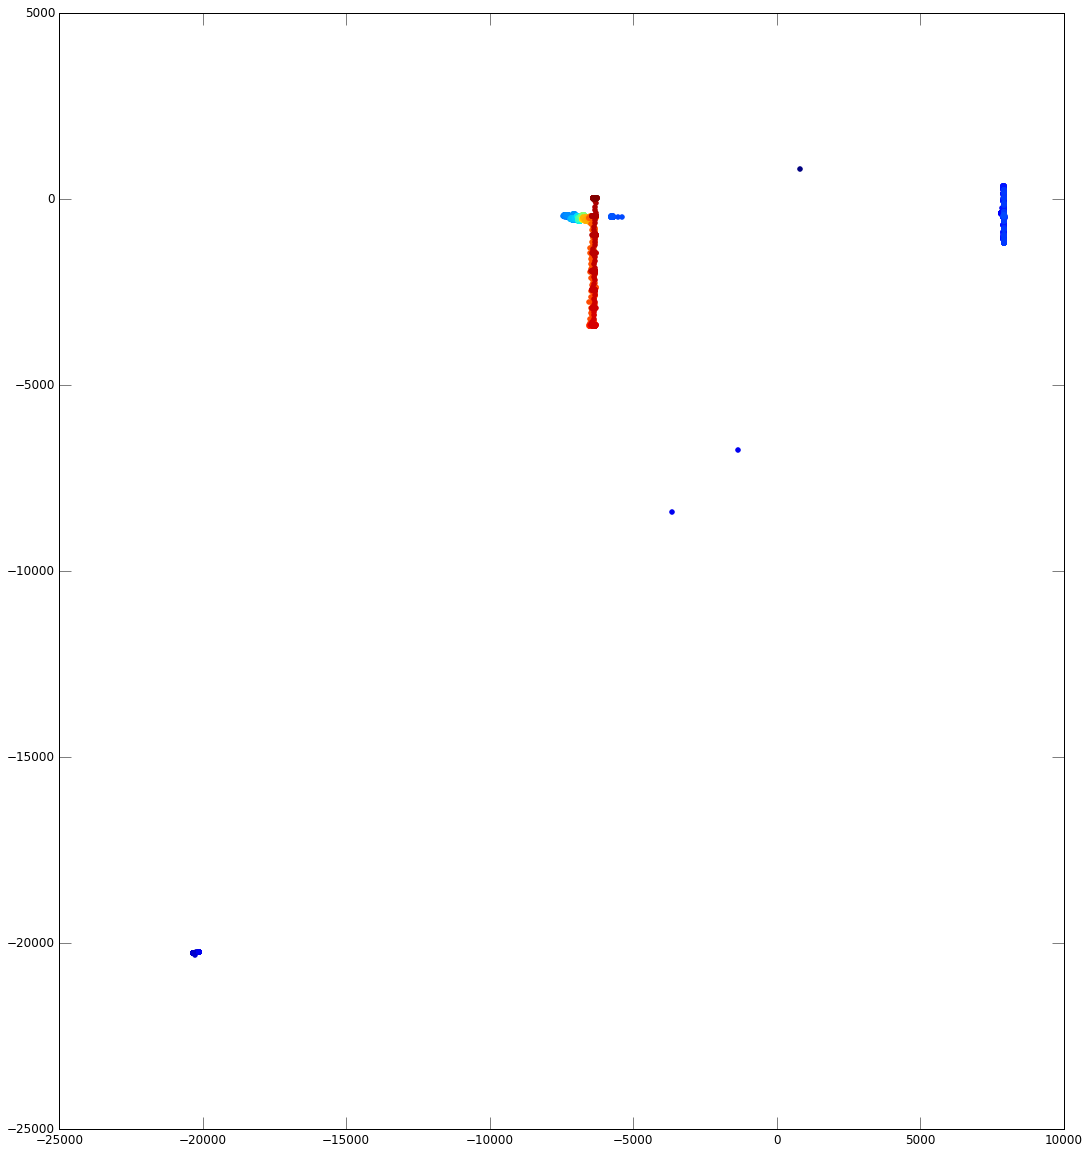

In [40]:
from IPython.html.widgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0,max=len(bpml5) )
display(f)
f.value=0
fig = plt.figure(figsize=(18,20))
mymap = plt.get_cmap('jet')
norm = plt.Normalize()
norm.autoscale(np.linspace(0,len(bpml5),len(bpml5)))
for i in range(len(bpml5)):
    plt.scatter(bpml5['BPM.7L5.B2'][i],bpml5['BPM.11L5.B2'][i],color=mymap(float(i)/len(bpml5)))
    f.value = i

# Dataframe mask example

In [12]:
dfex = pd.DataFrame({'AAA' :[4,5,6,7],'BBB':[10,20,30,40],'CCC':[100,50,-30,-50]});dfex

,AAA,BBB,CCC
0,4,10,100
1,5,20,50
2,6,30,-30
3,7,40,-50


In [17]:
dfex_mask = pd.DataFrame({'AAA':[True] *4,'BBB':[False]*4,'CCC':[True,False]*2});dfex_mask

,AAA,BBB,CCC
0,True,False,True
1,True,False,False
2,True,False,True
3,True,False,False


In [24]:
dfex.where(dfex_mask,0)

,AAA,BBB,CCC
0,4,0,100
1,5,0,0
2,6,0,-30
3,7,0,0


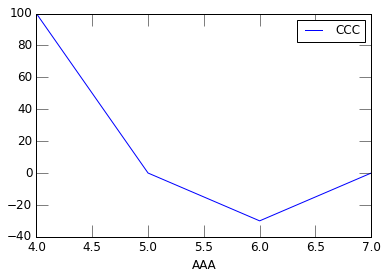

In [25]:
dfex.where(dfex_mask,0).plot(x='AAA',y='CCC')

In [27]:
dfex.loc[(dfex['BBB']<=0) | (dfex['CCC'] >0),'AAA']=0.1;dfex

,AAA,BBB,CCC
0,0.1,10,100
1,0.1,20,50
2,6.0,30,-30
3,7.0,40,-50


# Panel test

In [29]:
pf = pd.Panel({'dfs':tfsbpmr,'dfbpm':bpmr5})
pf.ix

In [14]:
tb = tfs[tfs["NAME"]=='MQ.11L5.B2']
tb

,NAME,KEYWORD,PARENT,S,L,LRAD,KICK,HKICK,VKICK,ANGLE,...,DPX,DPY,KMAX,KMIN,CALIB,POLARITY,APERTYPE,APER_1,N1,TILT
218,MQ.11L5.B2,QUADRUPOLE,MQ,438.8146576,3.1,0,0,0,0,0,...,0.03990041431,-0.001215973403,223,6.575,0.01878685762,1,CIRCLE,0,0,0


In [7]:
%save -f TimberGetDataClass.py 3

The following commands were written to file `TimberGetDataClass.py`:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import csv
import glob
import datetime
import collections
import time
import subprocess
import os
from scipy import optimize as opt
from scipy import constants as const
from StringIO import StringIO
from matplotlib import rc,rcParams
from matplotlib.patches import Rectangle
import itertools

# simdata
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import scatter_matrix

class LHCfill(object):
    # names of timberdata we want to extract
    timbervarFBCTB1    = 'LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'
    timbervarFBCTB2    = 'LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'

    timbervarBQMB1L   = 'LHC.BQM.B1:BUNCH_LENGTHS'
    timbervarBQMB1F   = 'LHC.BQM.B1:FILLED_BUCKETS'

    timbervarBQMB2L   = 'LHC.BQM.B2:BUNCH_LENGTHS'
    timbervarBQMB2F   = 'LHC.BQM.B2:FILL

In [38]:
class CTE(object):
    intensityout  = 'intensity.out'
    emittanceout  = 'emittance.out'
    ibsout        = 'ibs.out'
    luminosityout = 'luminosity.out'
    oldheaders = ['sim.turn', 't(hours)', 
               'N1_macro', 'N1_real', 'NlostLum1', 'Sum', 
               'NlostDebunch1','Sum.1', 'NLostBet1', 'Sum.2', 'NlostMom1', 'Sum.3', 
               'N2_macro', 'N2_real', 'NlostLum2','Sum.4', 
               'NlostDebunch2', 'SumNLostBet2', 'Sum.5', 'NlostMom2', 'Sum.6','']

    oldlumiheader = ['sim.turn','t(hours)','L(cm^-2 s^-1)' ,'reduction factor','Beta']
    
    def __init__(self,path):
        self.path = path
        self.intensity, self.emit, self.ibs, self.lumi = self.loaddata()
        self.macropartconv =  self.intensity['N1_real'].iloc[0]/self.intensity['N1_macro'].iloc[0]
        
    def loaddata(self):
        intensfile    = self.path + '/' + self.intensityout
        emitfile      = self.path + '/' + self.emittanceout
        lumifile      = self.path + '/' + self.luminosityout
        ibsfile       = self.path + '/' + self.ibsout
        
        intensitysimdata = pd.read_csv(intensfile,skiprows=[0,1],names=self.oldheaders,
                                       delim_whitespace=True,index_col=None)
        emittancesimdata = pd.read_csv(emitfile,skiprows=[1],delim_whitespace=True,index_col=None)
        ibssimdata       = pd.read_csv(ibsfile,skiprows=[1],delim_whitespace=True,index_col=None)
        lumisimdata      = pd.read_csv(lumifile,skiprows=[0,1],delim_whitespace=True,
                                       names=self.oldlumiheader,index_col=None)
        return intensitysimdata,emittancesimdata,ibssimdata,lumisimdata

In [39]:
%save -f CTEGetDataClass.py 38

The following commands were written to file `CTEGetDataClass.py`:
class CTE(object):
    intensityout  = 'intensity.out'
    emittanceout  = 'emittance.out'
    ibsout        = 'ibs.out'
    luminosityout = 'luminosity.out'
    oldheaders = ['sim.turn', 't(hours)', 
               'N1_macro', 'N1_real', 'NlostLum1', 'Sum', 
               'NlostDebunch1','Sum.1', 'NLostBet1', 'Sum.2', 'NlostMom1', 'Sum.3', 
               'N2_macro', 'N2_real', 'NlostLum2','Sum.4', 
               'NlostDebunch2', 'SumNLostBet2', 'Sum.5', 'NlostMom2', 'Sum.6','']

    oldlumiheader = ['sim.turn','t(hours)','L(cm^-2 s^-1)' ,'reduction factor','Beta']
    
    def __init__(self,path):
        self.path = path
        self.intensity, self.emit, self.ibs, self.lumi = self.loaddata()
        self.macropartconv =  self.intensity['N1_real'].iloc[0]/self.intensity['N1_macro'].iloc[0]
        
    def loaddata(self):
        intensfile    = self.path + '/' + self.intensityout
        emitfile      = self.path +

In [31]:
ccte = CTE('/afs/cern.ch/work/t/tomerten/CTEJOBS/HI2016/Stableb4leveled/')

In [37]:
ccte.intensity.plot(x='t(hours)',y='N1_real')
plt.show()

In [335]:
with open(fn1,'rb') as f:
    reader = csv.reader(f)
    linenumber=1
    try:
        for row in reader:
            linenumber +=1
    except Exception as e:
        print (('Error in line %d: %s %s  '% (linenumber,str(type(e)),e.message)))
        